# Load library

In [8]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import my_utils as mu
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torchvision # used to load data
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

# Load Data and transform data

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Resize((32,32)),
     transforms.Normalize((0.1307,), (0.3081,))]) #Normalise data

# Loading training and testing set
batch_size = 64
trainset = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transform) # 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Visualise Inputs

In [14]:
classes = ('0','1', '2', '3', '4', '5', '6', '7', '8', '9')

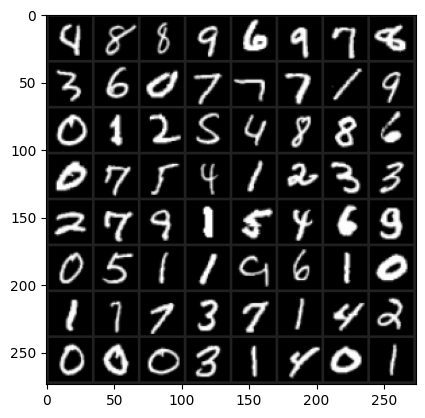

4     8     8     9     6     9     7     8     3     6     0     7     7     7     1     9     0     1     2     5     4     8     8     6     0     7     5     4     1     2     3     3     2     7     9     1     5     4     6     9     0     5     1     1     9     6     1     0     1     7     7     3     7     1     4     2     0     0     0     3     1     4     0     1    


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to show a grid of images
def imshow(img):
    img = img * 0.3081 + 0.1307  # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# VGG 16 Model

In [18]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs):
        super(VGGBlock, self).__init__()
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            in_channels = out_channels
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            VGGBlock(1, 64, 2),       # Block 1
            VGGBlock(64, 128, 2),     # Block 2
            VGGBlock(128, 256, 3),    # Block 3
            VGGBlock(256, 512, 3),    # Block 4
            VGGBlock(512, 512, 3)     # Block 5
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 4096),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)      
        x = self.classifier(x)    
        return x

# Load model, loss and optimiser

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
net = VGG16()
net.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Model Summary

In [25]:
summary(net, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
          VGGBlock-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

# Train model and visualise training and testing

In [28]:
def trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device, writer):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = mu.d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = mu.d2l.Timer()
    epoch_data = []
    writer.add_text('Hyperparameters', f'Learning Rate: {optimizer.param_groups[0]["lr"]}', 0)
    for epoch in range(num_epochs):
        metric = mu.d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], mu.d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                              (train_loss, train_acc, None))
                
        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_acc, epoch)
            
        test_acc = mu.evaluate_accuracy_gpu(net, test_iter, device)
        animator.add(epoch+1, (None, None, test_acc))
        writer.add_scalar('Test/Accuracy', test_acc, epoch)
        
        # Collect epoch data
        epoch_data.append({
            'epoch': epoch + 1,
            'loss': train_loss,
            'train_acc': train_acc,
            'test_acc': test_acc
        })
        
    # After all epochs, print the collected data
    print("-------------------------------------------------------")
    for data in epoch_data:
        print(f"Epoch {data['epoch']}, Loss: {data['loss']:.3f}, "
              f"Train Acc: {data['train_acc']:.3f}, Test Acc: {data['test_acc']:.3f}")
        
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(device)}')

    
    writer.close()


-------------------------------------------------------
Epoch 1, Loss: 0.137, Train Acc: 0.957, Test Acc: 0.990
Epoch 2, Loss: 0.030, Train Acc: 0.991, Test Acc: 0.990
Epoch 3, Loss: 0.018, Train Acc: 0.994, Test Acc: 0.993
Epoch 4, Loss: 0.011, Train Acc: 0.996, Test Acc: 0.992
Epoch 5, Loss: 0.007, Train Acc: 0.998, Test Acc: 0.993
Epoch 6, Loss: 0.006, Train Acc: 0.998, Test Acc: 0.995
Epoch 7, Loss: 0.005, Train Acc: 0.999, Test Acc: 0.994
Epoch 8, Loss: 0.003, Train Acc: 0.999, Test Acc: 0.995
Epoch 9, Loss: 0.003, Train Acc: 0.999, Test Acc: 0.994
Epoch 10, Loss: 0.002, Train Acc: 0.999, Test Acc: 0.994
5166.2 examples/sec on cuda


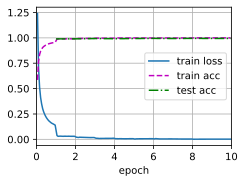

In [30]:
writer = SummaryWriter('runs/VGG16_MNIST')

num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
trainf(net, trainloader, testloader, loss, num_epochs, optimizer, device, writer)

In [31]:
torch.cuda.empty_cache()

# Visualise Test set predictions

In [33]:
def visualize_random_predictions(net, data_iter, device, num_images=10):
    net.eval()  
    images, labels = next(iter(data_iter))  
    
    # Randomly select image indices
    indices = np.random.choice(len(images), num_images, replace=False)
    
    images_selected = images[indices].to(device)
    labels_selected = labels[indices]
    
    with torch.no_grad():
        pred_probs = net(images_selected)
        pred_labels = torch.argmax(pred_probs, axis=1)
    
    images_selected = images_selected.cpu()
    pred_labels = pred_labels.cpu()
    
    # Plotting
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))  
    for i, ax in enumerate(axs.flat):
        ax.imshow(images_selected[i].reshape(32, 32), cmap='gray') 
        ax.set_title(f'Pred: {pred_labels[i]}, True: {labels_selected[i]}')
        ax.axis('off')
    
    plt.show()


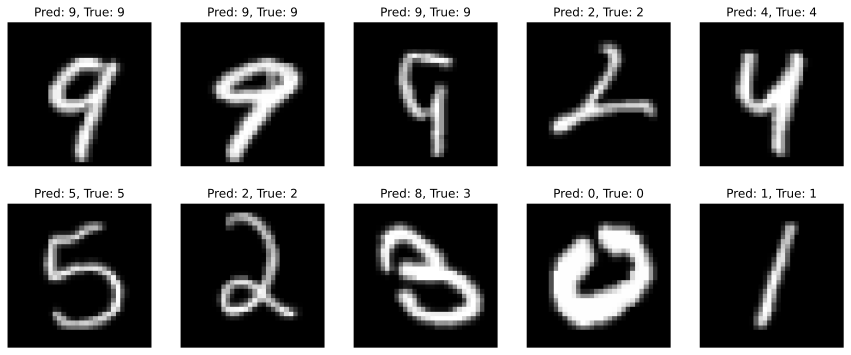

In [34]:
visualize_random_predictions(net, testloader, device)